In [1]:
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from scipy.stats import zscore

import pandas as pd
pd.options.display.max_columns = None

In [2]:
# Load datasets

APPL_DATA_CSV_PATH = 'data/appl_data.csv'
appl_df = pd.read_csv( APPL_DATA_CSV_PATH, header=0 )

BEHAV_ON_SITE_CSV_PATH = 'data/behav_on_site.csv'
behav_df = pd.read_csv( BEHAV_ON_SITE_CSV_PATH, header=0 )

IS_DEFAULT_CSV_PATH = 'data/is_default.csv'
isdef_df = pd.read_csv( IS_DEFAULT_CSV_PATH, header=0 )

In [3]:
# Merge application with target data

applications_df = pd.merge(
    left=appl_df, right=isdef_df,
    how='left',
    on=['appl_id']
)

del appl_df, isdef_df
gc.collect()

59

In [4]:
# Work on behavioral dataset

behav_df['create_time'] = pd.to_datetime( behav_df['create_time'] )

In [5]:
# browser: leave only significant ones; merge similar ones;

behav_df['binned_browser'] = behav_df['browser'].map({
    'Opera': 1, 'Opera Mini': 1,
    'Internet Explorer': 2, 'Edge': 2,   
    'iPod': 3, 'iPhone': 3, 'iPad': 3,
    'Android': 4,
    'Firefox': 5,
    'Chrome': 6,
    'Yandex': 7,
    'Safari': 8
})
behav_df['binned_browser'] = behav_df['binned_browser'].fillna( 9 )
behav_df['binned_browser'] = behav_df['binned_browser'].astype( int )

# platform: leave only significant ones; merge similar ones;
behav_df['binned_platform'] = behav_df['platform'].map({
    'Apple': 1, 'iPod': 1, 'iPad': 1,
    'iPhone': 2,
    'Linux': 3,
    'Android': 4,
    'Windows': 5,    
})
behav_df['binned_platform'] = behav_df['binned_platform'].fillna( 6 )
behav_df['binned_platform'] = behav_df['binned_platform'].astype( int )

In [6]:
# Work on applications dataset

# Convert date/datetime features to pd.datetime format

applications_df['app_crtime'] = pd.to_datetime( applications_df['app_crtime'] )
applications_df['birth'] = pd.to_datetime( applications_df['birth'] )
applications_df['pass_bdate'] = pd.to_datetime( applications_df['pass_bdate'] )
applications_df['lived_since'] = pd.to_datetime( applications_df['lived_since'] )
applications_df['is_same_reg_lived_since'] = pd.to_datetime( applications_df['is_same_reg_lived_since'] )
applications_df['jobsworksince'] = pd.to_datetime( applications_df['jobsworksince'] )

In [7]:
# Fix invalid values

# Fix monthlyincome where monthlyincome < 200 (8 observations) or montlycost < 200 (146 observations)
# Assume some missed *1000
too_small_income_indices = applications_df[applications_df['monthlyincome'] < 200].index
too_small_expenses_indices = applications_df[applications_df['monthlycost'] < 200].index

applications_df.loc[too_small_income_indices, 'monthlyincome'] *= 1000
applications_df.loc[too_small_expenses_indices, 'monthlycost'] *= 1000

In [8]:
# Fix max_age_child where quantity_child=0 but max_age_child!=0

# All observations are old enough to have a child
# Assume these observations have 1 child

invalid_maxagechild_indices = applications_df[
    (applications_df['quantity_child'] == 0) &
    (applications_df['max_age_child'] != 0)
].index

applications_df.loc[invalid_maxagechild_indices, 'quantity_child'] = 1

In [9]:
# Fix NaN values

# 'pass_bdate' feature: 
# Assume they got passport in the age of 16 yo

# display( 'pass_bdate nan shape:', applications_df[ applications_df['pass_bdate'].isnull() ].shape )

pass_bdate_fill_value = applications_df['birth'] + np.timedelta64(16, 'Y')
applications_df['pass_bdate'] = applications_df['pass_bdate'].fillna( pass_bdate_fill_value )

In [10]:
# 'max_age_child' feature:
# There are observations with quantity_child=0, but max_age_child=np.nan : in these cases, assume max_age_child=0
# zero_children_maxage_nan = applications_df[ (applications_df['quantity_child'] == 0) & (applications_df['max_age_child'].isnull()) ]

# display( zero_children_maxage_nan['quantity_child'].value_counts() )

applications_df['max_age_child'] = applications_df['max_age_child'].fillna( 0 )

In [11]:
# 'jobsworksince' feature:
# Because later this feature will be transformed into 'days jobs work since' as app_crtime-jobsworksince,
# assume value of this feature will equal to app_crtime, so that 'days jobs work since' will be equal to "0"

# display( applications_df[ applications_df['jobsworksince'].isnull() ] )

applications_df['jobsworksince'] = applications_df['jobsworksince'].dt.date
fixed_jobsworksince = applications_df['jobsworksince'].fillna( applications_df['app_crtime'].dt.date )
applications_df['jobsworksince'] = fixed_jobsworksince

In [12]:
# 'empl_type' and 'empl_worker_count'
# 945/946 observations have NaN values in empl_type and empl_worker_count at the same time
# This might suggest that there is 'other number of workers' for some 'other_empl_type' job - replacing this way is too risky (946 observations)

# display( applications_df[ applications_df['empl_type'].isnull() ] )
# display( applications_df[ (applications_df['empl_type'].isnull()) & (applications_df['empl_worker_count'].isnull()) ].shape )

# Replace the values after grouping by certain 'empl_state' and getting most common 'empl_type' and 'empl_worker_count' for that 'empl_state' group
# empl_state_groupby = applications_df[ ['empl_state', 'empl_type', 'empl_worker_count'] ].groupby( by='empl_state' )
# for name, group in empl_state_groupby:
#     group_nonan = group.dropna()
#     print(name)
#     print( group['empl_type'].mean() )
#     print( group['empl_worker_count'].mean() )
#     display(group_nonan.shape, group.shape)

applications_df['empl_type'] = applications_df['empl_type'].fillna( 0 )  # some 'other' employment type
applications_df['empl_worker_count'] = applications_df['empl_worker_count'].fillna( 0 )  # some 'other' number of workers

In [13]:
# 'education_area'

# Observations with empty 'education_area' have 'education' in (3, 5, 6)
# By looking at 'education' (3,5,6) groups and their salary/income values,
# these 'education' categories have lowest median income / expenses values.
# Observations with empty 'education_area' have median income 6500 and median expenses 3000
# The same values of income/expenses are in education category "6", "3" or "5"
# However, all "education_area" values in (3,5,6) education categories are NaN

# Assume there is some 'other' education area

# display( applications_df[applications_df['education_area'].isnull()] )

# display( applications_df[applications_df['education_area'].isnull()]['education'].value_counts() )

# education_groupby = applications_df.groupby( by='education' )
# for name, group in education_groupby:
#     print(name)
#     print(group['monthlyincome'].median())
#     print(group['monthlycost'].median())

# display(
#     applications_df[applications_df['education_area'].isnull()]['monthlycost'].median()
# )

# display(
#     applications_df[ applications_df['education'] == 6 ]['education_area'].value_counts()  # -> all 'education_area' are NaN valuess
# )
# display(
#     applications_df[ applications_df['education'] == 5 ]['education_area'].value_counts()  # -> all 'education_area' are NaN valuess
# )
# display(
#     applications_df[ applications_df['education'] == 3 ]['education_area'].value_counts()  # -> all 'education_area' are NaN valuess
# )

applications_df['education_area'] = applications_df['education_area'].fillna( 0 )

In [14]:
# applications_df.isnull().sum()

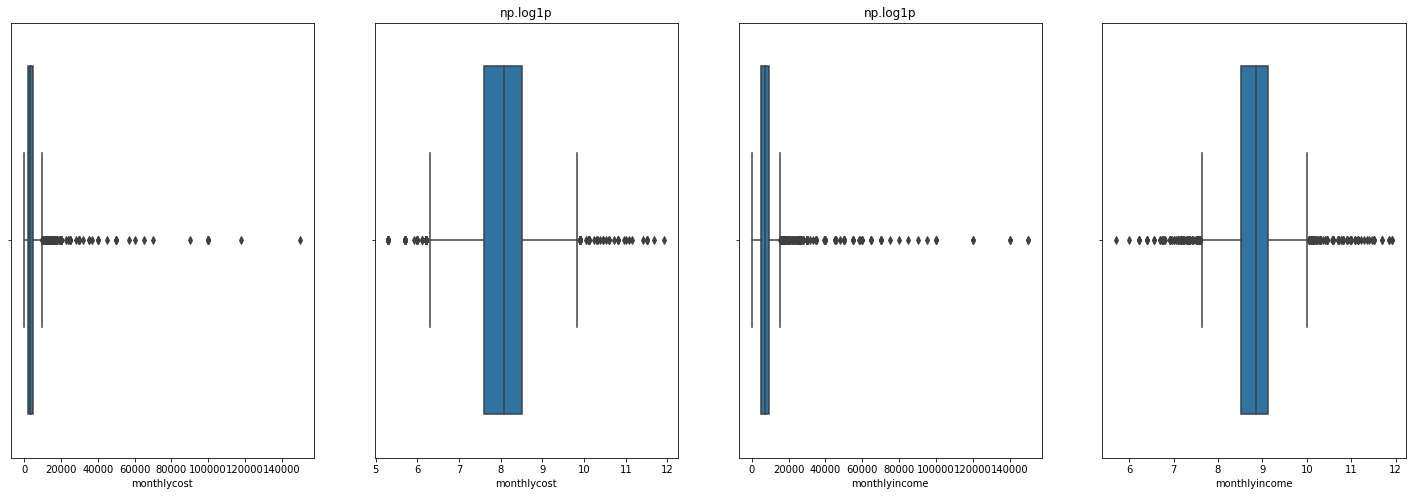

In [15]:
# Remove outliers in monthlyincome and monthlycost
# Only remove data in training set (where df!=np.nan)

# Box plots

fig, ax = plt.subplots( 1, 4, figsize=(25, 8) )

sns.boxplot(
    applications_df['monthlycost'],
    hue=applications_df['df'],
    ax=ax[0]
)

sns.boxplot(
    np.log1p( applications_df['monthlycost'] ),
    hue=applications_df['df'],
    ax=ax[1]
)
ax[1].set_title('np.log1p')

sns.boxplot(
    applications_df['monthlyincome'],
    hue=applications_df['df'],
    ax=ax[2]
)
ax[2].set_title('np.log1p')

sns.boxplot(
    np.log1p( applications_df['monthlyincome'] ),
    hue=applications_df['df'],
    ax=ax[3]
)

plt.show()

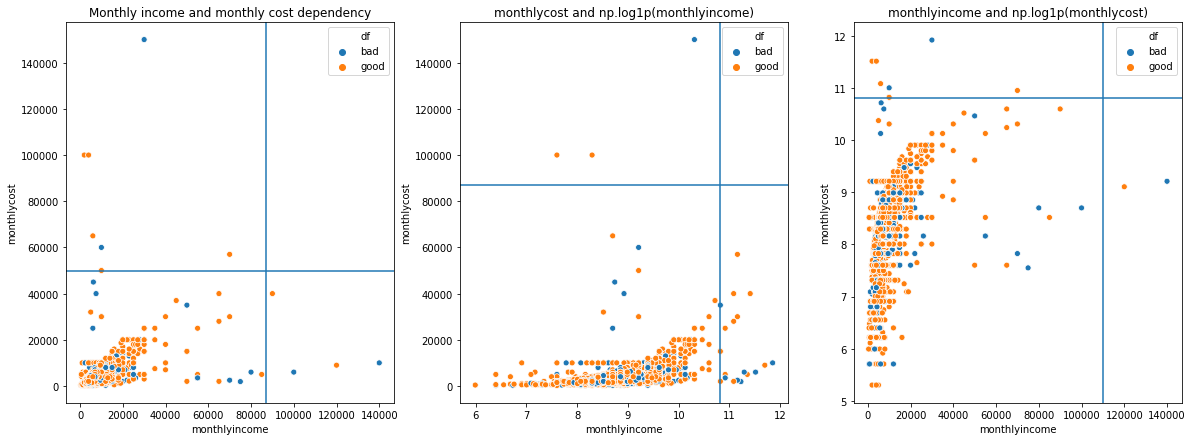

In [16]:
# Scatter plots
# By plotting with hue ensure all the data are from training set
fig, ax = plt.subplots( 1, 3, figsize=(20, 7) )
sns.scatterplot(
    x='monthlyincome', y='monthlycost',
    hue='df',
    data=applications_df,
    ax=ax[0]
)
ax[0].axhline(50000)
ax[0].axvline(87000)
ax[0].set_title('Monthly income and monthly cost dependency')

sns.scatterplot(
    np.log1p(applications_df['monthlyincome']),
    applications_df['monthlycost'],
    hue=applications_df['df'],
    ax=ax[1]
)
ax[1].axhline(87000)
ax[1].axvline( np.log1p(50000) )
ax[1].set_title('monthlycost and np.log1p(monthlyincome)')

sns.scatterplot(
    applications_df['monthlyincome'],
    np.log1p(applications_df['monthlycost']),
    hue=applications_df['df'],
    ax=ax[2]
)
ax[2].axhline( np.log1p(49000) )
ax[2].axvline(110000)
ax[2].set_title('monthlyincome and np.log1p(monthlycost)')

plt.show()

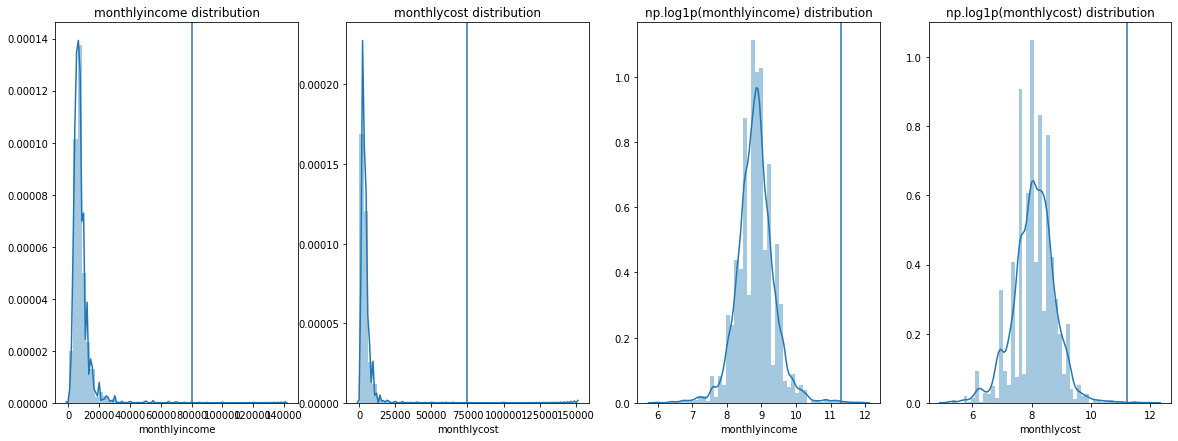

In [17]:
# Distributions
fig, ax = plt.subplots( 1, 4, figsize=(20, 7) )
sns.distplot(
    applications_df[ applications_df['df'].isnull() == False ]['monthlyincome'],
    ax=ax[0]
)
ax[0].axvline(80000)
ax[0].set_title('monthlyincome distribution')

sns.distplot(
    applications_df[ applications_df['df'].isnull() == False ]['monthlycost'],
    ax=ax[1]
)
ax[1].axvline(75000)
ax[1].set_title('monthlycost distribution')

sns.distplot(
    np.log1p( applications_df[ applications_df['df'].isnull() == False ]['monthlyincome'] ),
    ax=ax[2]
)
ax[2].axvline( np.log1p(80000) )
ax[2].set_title('np.log1p(monthlyincome) distribution')

sns.distplot(
    np.log1p( applications_df[ applications_df['df'].isnull() == False ]['monthlycost'] ),
    ax=ax[3]
)
ax[3].axvline( np.log1p(75000) )
ax[3].set_title('np.log1p(monthlycost) distribution')

plt.show()

In [18]:
# z-score : std relationship

z_monthlycost = np.abs( zscore(applications_df[applications_df['df'].isnull() == False]['monthlycost']) )
# applications_df = applications_df.drop( np.where( z_monthlycost > 5 )[0] )

z_monthlyincome = np.abs( zscore(applications_df[applications_df['df'].isnull() == False]['monthlyincome']) )
# applications_df = applications_df.drop( np.where( z_monthlyincome > 5 )[0] )

intercept = np.intersect1d( np.where(z_monthlyincome > 4)[0], np.where( z_monthlycost > 4)[0] )
display( 'outliers found by z-score:', intercept )
applications_df = applications_df.drop( intercept )

'outliers found by z-score:'

array([ 136,  265, 1235, 2193, 2919, 3214, 3298, 3369, 3813, 3897])

In [19]:
# Dummy drop: cost < 50k and income < 87k - 6 values

dummy_outliers = applications_df[
    (applications_df['monthlycost'] > 50000) &
    (applications_df['monthlyincome'] < 87000) &
    (applications_df['df'].isnull() == False)
].index

applications_df = applications_df.drop( dummy_outliers )

In [20]:
# Check skewness and kurtosis for monthlyincome/monthlycost

display(
    'monthlyincome skew: {0:.4f}, kurtosis: {1:.4f}'.format(
        applications_df['monthlyincome'].skew(), applications_df['monthlyincome'].kurt()
    )
)

display(
    'monthlycost skew: {0:.4f}, kurtosis: {1:.4f}'.format(
        applications_df['monthlycost'].skew(), applications_df['monthlycost'].kurt()
    )
)

# skew_fixes = [np.sqrt, np.log1p, np.log10, np.sqrt ]  # **1/3
# for fix in skew_fixes:
#     display(
#         fix,
#         'monthlyincome skew: {0:.4f}, kurtosis: {1:.4f}'.format(
#             fix(applications_df['monthlyincome']).skew(), fix(applications_df['monthlyincome']).kurt()
#         )
#     )
#     display(
#         fix,
#         'monthlycost skew: {0:.4f}, kurtosis: {1:.4f}'.format(
#             fix(applications_df['monthlycost']).skew(), fix(applications_df['monthlycost']).kurt()
#         )
#     )

display(
    'log1p-transformed monthlyincome skew: {0:.4f}, kurtosis: {1:.4f}'.format(
        np.log1p(applications_df['monthlyincome']).skew(), np.log1p(applications_df['monthlyincome']).kurt()
    )
)

display(
    'log1p-transformed monthlycost skew: {0:.4f}, kurtosis: {1:.4f}'.format(
        np.log1p(applications_df['monthlycost']).skew(), np.log1p(applications_df['monthlycost']).kurt()
    )
)

'monthlyincome skew: 8.7991, kurtosis: 129.5955'

'monthlycost skew: 11.3052, kurtosis: 225.5265'

'log1p-transformed monthlyincome skew: 0.1824, kurtosis: 3.1994'

'log1p-transformed monthlycost skew: -0.2202, kurtosis: 1.4053'

In [21]:
applications_df['monthlycost'] = np.log1p( applications_df['monthlycost'] )
applications_df['monthlyincome'] = np.log1p( applications_df['monthlyincome'] )

In [22]:
# Fix unbalanced classes

# deal with unbalanced target class on cross-validation step

In [23]:
# Add features to applications_df

behav_client_groupby = behav_df.groupby( by='client_id' )


def apply_most_freq_colname( client_id, col_name ):
    selected_group = behav_client_groupby.get_group( client_id )
    most_freq_colname_value = selected_group[col_name].mode()[0]
    return most_freq_colname_value


# Most frequent browser used        
applications_df['top_browser'] = applications_df['client_id'].apply(
    lambda x: apply_most_freq_colname( x, 'binned_browser' )
)

# Most frequent platform used
applications_df['top_platform'] = applications_df['client_id'].apply(
    lambda x: apply_most_freq_colname( x, 'binned_platform' )
)

In [24]:
# Total number of visits by certain client

def apply_total_visits_cnt( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    total_visits = selected_group.shape[0]
    return total_visits


applications_df['total_visits_cnt'] = applications_df['client_id'].apply(
    lambda x: apply_total_visits_cnt( x )
)
applications_df['total_visits_cnt'] = np.log1p( applications_df['total_visits_cnt'] )

In [25]:
# Number of devices used by certain client

def apply_num_of_devices( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    total_devices = selected_group['device_id'].nunique()
    return total_devices


applications_df['total_devices_cnt'] = applications_df['client_id'].apply(
    lambda x: apply_num_of_devices( x )
)

In [26]:
# Time spent on website (log-transformed)

def apply_timespent( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    selected_group = selected_group.sort_values( by='create_time' )
    time_spent_series = selected_group['create_time'].shift(-1) - selected_group['create_time']
    time_spent_series = time_spent_series[
        (time_spent_series / np.timedelta64(90, 'm')) <= 1.0
    ]
    total_time_spent = np.sum( time_spent_series )
    return total_time_spent


applications_df['total_time_spent'] = applications_df['client_id'].apply(
    lambda x: apply_timespent( x )
)
applications_df['total_time_spent'] = applications_df['total_time_spent'] / np.timedelta64(1, 'm')
applications_df['total_time_spent'] = np.log1p( applications_df['total_time_spent'] )

In [27]:
# Average time spent on single visit time (log-transformed)

applications_df['avg_time_per_page'] = applications_df['total_time_spent'] / applications_df['total_visits_cnt']

In [28]:
# Number of unique days customer visited any webpage

def apply_visit_days_cnt( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    visit_days_cnt = selected_group['create_time'].dt.day.nunique()
    return visit_days_cnt
    

applications_df['visit_days_cnt'] = applications_df['client_id'].apply(
    lambda x: apply_visit_days_cnt( x )
)

In [29]:
# Most frequent day of week to visit the website

def apply_visit_top_dayofweek( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    visit_days = selected_group['create_time'].dt.dayofweek
    most_popular_visitday = visit_days.mode()[0]
    return most_popular_visitday


applications_df['visit_top_dayofweek'] = applications_df['client_id'].apply(
    lambda x: apply_visit_top_dayofweek( x )
)

In [30]:
# Most frequent hour of day to visit the website

def apply_visit_top_dayhour( client_id ):
    selected_group = behav_client_groupby.get_group( client_id )
    visit_hours = selected_group['create_time'].dt.hour
    most_popular_hour = visit_hours.mode()[0]
    return most_popular_hour

    
applications_df['visit_top_dayhour'] = applications_df['client_id'].apply(
    lambda x: apply_visit_top_dayhour( x )
)

In [31]:
# Data binning

# top visit hour: <=7h, 8-12, 13-20, 21-24
def apply_top_visit_hour( visit_top_dayhour ):
    if visit_top_dayhour <= 7:
        return 1
    elif visit_top_dayhour <= 12:
        return 2
    elif visit_top_dayhour <= 20:
        return 3
    else:
        return 4


applications_df['binned_visit_top_dayhour'] = applications_df['visit_top_dayhour'].apply(
    lambda x: apply_top_visit_hour( x )
)

In [32]:
# weekend indicator

applications_df['flg_is_weekend'] = applications_df['visit_top_dayofweek'].apply(
    lambda x: 1 if x >= 5 else 0
)

In [33]:
# fam_status
applications_df['binned_fam_status'] = applications_df['fam_status'].map({
    1:1, 2:1, 4:1,
    3:2,
    5:3
})

In [34]:
# quantity_child
applications_df['binned_quantity_child'] = applications_df['quantity_child'].apply(
    lambda quantity_child: quantity_child if quantity_child <= 4 else 5
)

In [35]:
# max_age_child

def apply_max_age_bins( max_age_child ):
    if max_age_child <= 5:
        return 1
    elif max_age_child <= 12:
        return 2
    elif max_age_child <= 18:
        return 3
    elif max_age_child <= 25:
        return 4
    else:
        return 5


applications_df['binned_max_age_child'] = applications_df['max_age_child'].apply(
    lambda x: apply_max_age_bins( x )
)

In [36]:
# property

applications_df['binned_property'] = applications_df['property'].map({
    1:1, 2:1,
    4:2,
    3:3, 5:3,
    6:4    
})

In [37]:
# region

applications_df['binned_region'] = applications_df['region'].map({
    7:1, 17:1,
    1:2, 4:2, 8:2, 9:2, 10:2, 11:2, 13:2, 22:2
})
applications_df['binned_region'] = applications_df['binned_region'].fillna( 3 )
applications_df['binned_region'] = applications_df['binned_region'].astype( int )

In [38]:
# region_reg

applications_df['binned_region_reg'] = applications_df['region_reg'].map({
    1:1, 2:1, 9:1, 19:1, 21:1,
    6:2, 8:2, 10:2, 11:2, 12:2, 14:2, 16:2, 17:2, 18:2, 22:2, 23:2, 24:2, 25:2, 26:2, 27:2
})
applications_df['binned_region_reg'] = applications_df['binned_region_reg'].fillna( 3 )
applications_df['binned_region_reg'] = applications_df['binned_region_reg'].astype( int )

In [39]:
# work_experience

def apply_work_experience_bins( work_experience ):
    if work_experience >= 37:
        return 1
    elif work_experience >= 20:
        return 2
    elif work_experience >= 14:
        return 3
    elif work_experience >= 9:
        return 4
    elif work_experience >= 6:
        return 5
    else:
        return 6


applications_df['binned_work_experience'] = applications_df['work_experience'].apply(
    lambda x: apply_work_experience_bins( x )
)

In [40]:
# empl_state

applications_df['binned_empl_state'] = applications_df['empl_state'].map({
    1:1, 3:1, 4:1, 5:1,
    2:2,
    6:3
})

In [41]:
# empl_type

applications_df['binned_empl_type'] = applications_df['empl_type'].map({
    1:1, 2:1, 5:1, 7:1, 8:1, 10:1, 11:1,
    3:2, 4:2, 6:2, 9:2, 12:2, 13:2,
    0:3
})

In [42]:
# empl_worker_count

applications_df['binned_empl_worker_count'] = applications_df['empl_worker_count'].map({
    1:1,
    2:2, 5:2, 6:2,
    3:3, 4:3,
    0:4
})

In [43]:
# education_area

applications_df['binned_education_area'] = applications_df['education_area'].map({
    1:1,
    5:2, 6:2, 7:2, 8:2,
    2:3, 4:3, 9:3, 11:3,
    3:4, 10:4,    
    0:5    
})

In [44]:
# education

applications_df['binned_education'] = applications_df['education'].map({
    1:1, 2:1, 4:1, 6:1,
    3:2, 5:2,
    7:3,
})

In [49]:
# Feature engineering

# Flag observations where monthlyincome < monthlycost (161 observations)
observations_to_flag = applications_df[ applications_df['monthlyincome'] < applications_df['monthlycost'] ]
applications_df.loc[observations_to_flag.index, 'flg_inc_lt_cost'] = 1
applications_df['flg_inc_lt_cost'] = applications_df['flg_inc_lt_cost'].fillna( 0 )

# Flag observations where monthlyincome == monthlycost (302 observations)
observations_to_flag = applications_df[ applications_df['monthlyincome'] == applications_df['monthlycost'] ]
applications_df.loc[observations_to_flag.index, 'flg_inc_eq_cost'] = 1
applications_df['flg_inc_eq_cost'] = applications_df['flg_inc_eq_cost'].fillna( 0 )

# Log-transformed difference between income and expenses: money left at the end of the month
applications_df['inc_cost_diff'] = applications_df['monthlyincome'] - applications_df['monthlycost']

# Percentage of money left at the end of the month
applications_df['inc_cost_diff_pct'] = applications_df['inc_cost_diff'] * 100.0 / applications_df['monthlyincome']

# Weird polynomial / relation feature for cost / income features
applications_df['weird_sqrtcost_inc'] = np.sqrt(applications_df['monthlycost']) / applications_df['monthlyincome']

# Weird polynomial feature #2 for cost / income features
applications_df['weird_sqrcost_inc'] = applications_df['monthlycost'] ** 2 / applications_df['monthlyincome']

# Interaction between cost and income
applications_df['intrct_income_cost'] = applications_df['monthlyincome'] * applications_df['monthlycost']

# Flag if client has a child
applications_df['flg_has_child'] = applications_df['max_age_child'].apply( lambda x: 1 if x==0.0 else 0 )

# Region and Registration region interaction
applications_df['interct_region_regionreg'] = applications_df['region'] * applications_df['region_reg']

# Binned region and Binned registration region interaction
applications_df['interct_binregion_binregionreg'] = applications_df['binned_region'] * applications_df['binned_region_reg']

# Format 'birth' to 'days from birth to application creation time'
applications_df['days_from_birth'] = applications_df['app_crtime'].dt.date - applications_df['birth'].dt.date
applications_df['days_from_birth'] = applications_df['days_from_birth'].apply( lambda x: x.days )

# Bin 'days_from_birth' into several categories
def apply_days_from_birth_bins( x ):
    if x <= 20 * 365:
        return 1
    elif x <= 25 * 365:
        return 2
    elif x <= 30 * 365:
        return 3
    elif x <= 50 * 365:
        return 4
    else:
        return 5
applications_df['binned_days_from_birth'] = applications_df['days_from_birth'].apply(
    lambda x: apply_days_from_birth_bins( x )
)

# Format 'pass_bdate' to 'days from birth to date when was getting a passport'
applications_df['days_from_passbdate'] = applications_df['pass_bdate'].dt.date - applications_df['birth'].dt.date
applications_df['days_from_passbdate'] = applications_df['days_from_passbdate'].apply( lambda x: x.days )

# Bin 'days_from_passbdate' to identify scammers
def apply_days_from_passbdate_bins( x ):
    if x < 16 * 365:
        return 1
    elif x > 30 * 365:
        return 2
    else:
        return 3
applications_df['binned_days_from_passbdate'] = applications_df['days_from_passbdate'].apply(
    lambda x: apply_days_from_passbdate_bins( x )
)

# Format 'jobsworksince' to 'days from application date and start of the prev job'
applications_df['days_from_jobsworksince'] = applications_df['app_crtime'].dt.date - applications_df['jobsworksince']
applications_df['days_from_jobsworksince'] = applications_df['days_from_jobsworksince'].apply( lambda x: x.days )

# has_job - if jobsworksince = 0 -> no previous job / can't remember previous job / currently unemployed
applications_df['flg_has_job'] = applications_df['days_from_jobsworksince'].apply( lambda x: 1 if x == 0 else 0 )

# Last job employment days to birth days ratio
applications_df['employ_to_birth_ratio'] = applications_df['days_from_jobsworksince'] / applications_df['days_from_birth']

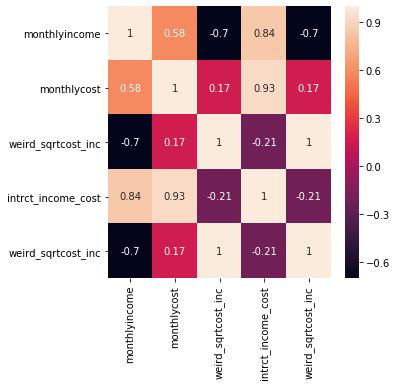

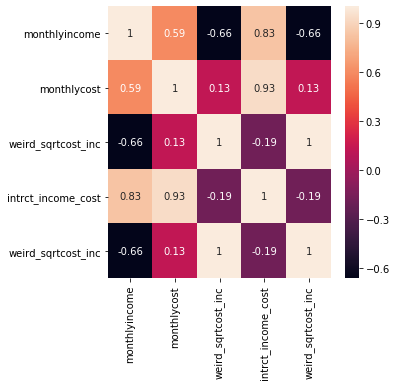

In [50]:
# Look at correlation

# Pearson correlation
fig = plt.figure( figsize=(5, 5) )
sns.heatmap(
#     applications_df.corr(),
    applications_df[ ['monthlyincome', 'monthlycost', 'weird_sqrtcost_inc', 'intrct_income_cost', 'weird_sqrtcost_inc'] ].corr(),
    annot=True
)
plt.autoscale()
plt.show()

fig = plt.figure( figsize=(5, 5) )
sns.heatmap(
#     applications_df.corr(method='spearman'),
    applications_df[ ['monthlyincome', 'monthlycost', 'weird_sqrtcost_inc', 'intrct_income_cost', 'weird_sqrtcost_inc'] ].corr(method='spearman'),
    annot=True
)
plt.autoscale()
plt.show()

In [51]:
# fig, ax = plt.subplots( figsize=(15, 15) )
# pd.plotting.scatter_matrix(
#     applications_df[ ['monthlyincome', 'monthlycost', 'weird_sqrtcost_inc', 'intrct_income_cost'] ], ax=ax
# )
# plt.autoscale()
# plt.show()

In [52]:
# feature scaling:
# skip - do that in modelling notebooks

In [53]:
# Save dataset with preprocessed data and new features

import pickle

pickle.dump( applications_df, open('preprocessed_applications_df.dataframe.pd', 'wb') )

In [54]:
applications_df.sample()

,appl_id,app_crtime,client_id,birth,gender,pass_bdate,fam_status,quantity_child,max_age_child,property,lived_since,is_same_reg_lived_since,region,region_reg,jobsworksince,work_experience,empl_state,empl_type,empl_worker_count,education_area,education,monthlyincome,monthlycost,df,top_browser,top_platform,total_visits_cnt,total_devices_cnt,total_time_spent,avg_time_per_page,visit_days_cnt,visit_top_dayofweek,visit_top_dayhour,binned_visit_top_dayhour,flg_is_weekend,binned_fam_status,binned_quantity_child,binned_max_age_child,binned_property,binned_region,binned_region_reg,binned_work_experience,binned_empl_state,binned_empl_type,binned_empl_worker_count,binned_education_area,binned_education,flg_inc_lt_cost,flg_inc_eq_cost,inc_cost_diff,inc_cost_diff_pct,weird_sqrtcost_inc,weird_sqrcost_inc,intrct_income_cost,flg_has_child,interct_region_regionreg,interct_binregion_binregionreg,days_from_birth,binned_days_from_birth,days_from_passbdate,binned_days_from_passbdate,days_from_jobsworksince,flg_has_job,app_month_num,employ_to_birth_ratio
6392,516339,2017-09-02 08:14:05+00:00,68433,1985-03-21,2,2003-12-29,4,1,0.0,1,2000-02-10,2000-02-10,3,4,2004-02-10,13,1,6.0,5.0,0.0,6,8.779711,8.216358,good,7,5,2.772589,1,4.048662,1.460246,1,5,8,2,1,1,1,1,1,3,3,4,1,2,2,5,1,0.0,0.0,0.563353,6.416532,0.326482,7.689153,72.137254,1,12,9,11853,4,6857,3,4953,0,9,0.417869


In [55]:
applications_df['df'] = applications_df['df'].fillna( 'test' )

In [57]:
# applications_df.to_excel( 'output.xslx', engine='openpyxl' )